# MODERN PORTFOLIO THEORY

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import statsmodels.formula.api as sm
import yfinance as yf
import matplotlib.pyplot as plt

class Portfolio:
    def __init__(self):
        self.positions = {}

    def set_holdings(self, symbol, weight):
        if symbol not in self.positions:
            self.positions[symbol] = {"weight": 0.0}

        # Ensure weight is within bounds [-1, 1]
        weight = max(-1.0, min(1.0, weight))

        # Update the weight for the symbol
        self.positions[symbol]["weight"] = weight

    def get_positions(self):
        return self.positions

    def liquidate(self):
        # Simulate liquidation by resetting all weights to 0
        for symbol in self.positions:
            self.positions[symbol]["weight"] = 0.0


class MeanVariance:
    def __init__(self):
        self.symbols = ["SPY", "MMM", "AXP", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO",
                        "DIS", "DD", "XOM", "GE", "GS", "HD", "IBM", "INTC", "JPM", "MCD",
                        "MRK", "MSFT", "NKE", "PFE", "PG", "TRV", "UNH", "VZ", "V", "WMT"]
        self.num = 21 * 12
        self.reb_feq = 21
        self.count = 0
        self.portfolio = Portfolio()

    def get_history(self, symbol):
        try:
            data = yf.download(symbol.info["symbol"], start="2014-01-01", end="2017-01-01")
            data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
            symbol.df = data[['log_return']].dropna()
        except Exception as e:
            print(f"Failed to download {symbol.info['symbol']}: {e}")

    def regression(self, symbols, spy):
        for i in symbols:
            df = pd.DataFrame({str(i.info["symbol"]): i.df['log_return'], 'SPY': spy.df['log_return']})
            i.model = sm.ols(formula=f"{str(i.info['symbol'])} ~ SPY", data=df).fit()
            i.intercept = i.model.params[0]
            i.beta = i.model.params[1]
            i.one_month = sum(i.df['log_return'].tail(21))

    def initialize(self):
        self.symbols = [yf.Ticker(symbol) for symbol in self.symbols]
        for symbol in self.symbols:
            self.get_history(symbol)

        self.spy = self.symbols[0]
        self.regression(self.symbols, self.spy)

    def on_data(self):
        print(f"\nProcessing data for count: {self.count}")

        if self.count == 0:
            for i in self.symbols:
                i.alpha = i.one_month - i.intercept - i.beta * self.spy.one_month

            self.long_list = [x for x in self.symbols if x.info["symbol"] != "UTX"]
            self.ticker_list = [str(x.info["symbol"]) for x in self.long_list]
            self.mean_list = [x.df['log_return'].mean() for x in self.long_list]
            self.cov_matrix = np.cov([x.df['log_return'] for x in self.long_list])

            optimizer = PortfolioOptimizer(self.ticker_list, self.mean_list, self.cov_matrix)
            optimizer.optimize()

            for i in self.long_list:
                self.portfolio.set_holdings(str(i.info["symbol"]), optimizer.opt_df.loc[str(i.info["symbol"]), 'weight'])
                print(f"Set holdings for {i.info['symbol']} to {optimizer.opt_df.loc[str(i.info['symbol']), 'weight']}")

            self.count += 1
            return

        if self.count < self.reb_feq:
            self.count += 1
            return

        if self.count == self.reb_feq:
            for i in self.symbols:
                self.get_history(i)

            self.regression(self.symbols, self.spy)
            self.portfolio.liquidate()
            print("Liquidated all positions.")
            self.count = 0

    def plot_mpt_graph(self):
        print("\nPlotting MPT graph...")

        # Extracting portfolio statistics for plotting
        portfolio_optimizer = PortfolioOptimizer(self.ticker_list, self.mean_list, self.cov_matrix)
        portfolio_optimizer.optimize()

        # Expected returns and standard deviations for the efficient frontier
        ef_returns, ef_std = self.generate_efficient_frontier(portfolio_optimizer)

        # Plot the efficient frontier
        plt.figure(figsize=(10, 6))
        plt.scatter(ef_std, ef_returns, c='red', marker='o', label='Efficient Frontier')

        # Plot individual stock points
        for i in self.long_list:
            plt.scatter(np.sqrt(i.df['log_return'].var() * 252), i.mean * 252, c='blue', marker='x', label=str(i.info['symbol']))

        # Plot the CML line
        risk_free_rate = 0.02  # Set your risk-free rate here
        cml_x = np.linspace(0, max(ef_std), 100)
        cml_y = risk_free_rate + ((ef_returns[-1] - risk_free_rate) / ef_std[-1]) * cml_x
        plt.plot(cml_x, cml_y, color='green', linestyle='--', label='Capital Market Line (CML)')

        plt.title('Modern Portfolio Theory (MPT) with Capital Market Line (CML)')
        plt.xlabel('Portfolio Standard Deviation (Risk)')
        plt.ylabel('Portfolio Expected Return')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("MPT graph plotted.")

    def generate_efficient_frontier(self, portfolio_optimizer):
        ef_returns = []
        ef_std = []

        for target_return in np.linspace(min(self.mean_list), max(self.mean_list), 100):
            # Set the target return and optimize for minimum standard deviation
            c = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},
                 {'type': 'eq', 'fun': lambda x: sum(x * self.mean_list) - target_return})
            res = minimize(portfolio_optimizer.target, portfolio_optimizer.x, args=(self.cov_matrix, self.mean_list),
                           method='SLSQP', constraints=c, bounds=portfolio_optimizer.bounds)

            # Calculate standard deviation for the optimized weights
            std = np.sqrt(np.dot(np.dot(res.x.T, self.cov_matrix), res.x) * 252)
            ef_returns.append(target_return * 252)
            ef_std.append(std)

        return ef_returns, ef_std


class PortfolioOptimizer:
    def __init__(self, ticker_list, mean_list, cov_matrix):
        self.tickers = ticker_list
        self.mean_list = mean_list
        self.cov_matrix = cov_matrix
        self.x = np.ones(len(self.tickers)) / len(self.tickers)
        self.bounds = [(-1, 1) for _ in range(len(self.tickers))]

    def optimize(self):
        print("\nOptimizing portfolio...")

        def target(x, sigma, mean):
            sr_inv = (np.sqrt(np.dot(np.dot(x.T, sigma), x) * 252)) / ((x.dot(mean)) * 252)
            return sr_inv

        c = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},
             {'type': 'ineq', 'fun': lambda x: 2 - sum([abs(i) for i in x])})
        res = minimize(target, self.x, args=(self.cov_matrix, self.mean_list), method='SLSQP', constraints=c, bounds=self.bounds)
        self.opt_weight = res.x
        self.exp_return = np.dot(self.mean_list, res.x) * 252
        self.std = np.sqrt(np.dot(np.dot(res.x.T, self.cov_matrix), res.x) * 252)
        self.opt_df = pd.DataFrame({'weight': res.x}, index=self.tickers)
        self.opt_df.index = self.opt_df.index.map(str)

        print("Optimization complete.")
        print(f"Optimal Weights:\n{self.opt_df}")
        print(f"Expected Return: {self.exp_return}")
        print(f"Portfolio Standard Deviation: {self.std}")

    def update(self, ticker_list, mean_list, cov_matrix):
        self.tickers = ticker_list
        self.mean_list = mean_list
        self.cov_matrix = cov_matrix
        self.x = np.ones(len(self.tickers)) / len(self.tickers)
        self.bounds = [(-1, 1) for _ in range(len(self.tickers))]
        self.optimize()


# Usage
mean_variance = MeanVariance()
mean_variance.initialize()
mean_variance.on_data()
mean_variance.plot_mpt_graph()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_91807/2490960217.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i.intercept = i.model.params[0]
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_91807/2490960217.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i.beta = i.model.params[1]
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_91807/2490960217.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

AttributeError: 'PortfolioOptimizer' object has no attribute 'target'

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_91807/3779822658.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i.intercept = i.model.params[0]
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_91807/3779822658.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  i.beta = i.model.params[1]
/var/folders/_y/0xw7_0ss0s3f4kfhj9xl96zw0000gn/T/ipykernel_91807/3779822658.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.ilo

AttributeError: 'Ticker' object has no attribute 'mean'

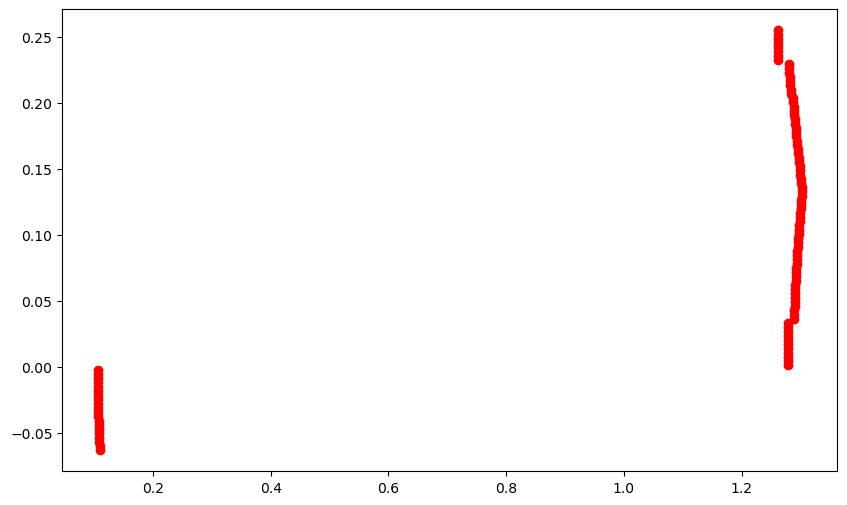

In [15]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import statsmodels.formula.api as sm
import yfinance as yf
import matplotlib.pyplot as plt

class Portfolio:
    def __init__(self):
        self.positions = {}

    def set_holdings(self, symbol, weight):
        if symbol not in self.positions:
            self.positions[symbol] = {"weight": 0.0}

        # Ensure weight is within bounds [-1, 1]
        weight = max(-1.0, min(1.0, weight))

        # Update the weight for the symbol
        self.positions[symbol]["weight"] = weight

    def get_positions(self):
        return self.positions

    def liquidate(self):
        # Simulate liquidation by resetting all weights to 0
        for symbol in self.positions:
            self.positions[symbol]["weight"] = 0.0


class MeanVariance:
    def __init__(self):
        self.symbols = ["SPY", "MMM", "AXP", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO",
                        "DIS", "DD", "XOM", "GE", "GS", "HD", "IBM", "INTC", "JPM", "MCD",
                        "MRK", "MSFT", "NKE", "PFE", "PG", "TRV", "UNH", "VZ", "V", "WMT"]
        self.num = 21 * 12
        self.reb_feq = 21
        self.count = 0
        self.portfolio = Portfolio()

    def get_history(self, symbol):
        try:
            data = yf.download(symbol.info["symbol"], start="2014-01-01", end="2017-01-01")
            data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))
            symbol.df = data[['log_return']].dropna()
        except Exception as e:
            print(f"Failed to download {symbol.info['symbol']}: {e}")

    def regression(self, symbols, spy):
        for i in symbols:
            df = pd.DataFrame({str(i.info["symbol"]): i.df['log_return'], 'SPY': spy.df['log_return']})
            i.model = sm.ols(formula=f"{str(i.info['symbol'])} ~ SPY", data=df).fit()
            i.intercept = i.model.params[0]
            i.beta = i.model.params[1]
            i.one_month = sum(i.df['log_return'].tail(21))

    def initialize(self):
        self.symbols = [yf.Ticker(symbol) for symbol in self.symbols]
        for symbol in self.symbols:
            self.get_history(symbol)

        self.spy = self.symbols[0]
        self.regression(self.symbols, self.spy)

    def on_data(self):
        print(f"\nProcessing data for count: {self.count}")

        if self.count == 0:
            for i in self.symbols:
                i.alpha = i.one_month - i.intercept - i.beta * self.spy.one_month

            self.long_list = [x for x in self.symbols if x.info["symbol"] != "UTX"]
            self.ticker_list = [str(x.info["symbol"]) for x in self.long_list]
            self.mean_list = [x.df['log_return'].mean() for x in self.long_list]
            self.cov_matrix = np.cov([x.df['log_return'] for x in self.long_list])

            optimizer = PortfolioOptimizer(self.ticker_list, self.mean_list, self.cov_matrix)
            optimizer.optimize()

            for i in self.long_list:
                self.portfolio.set_holdings(str(i.info["symbol"]), optimizer.opt_df.loc[str(i.info["symbol"]), 'weight'])
                print(f"Set holdings for {i.info['symbol']} to {optimizer.opt_df.loc[str(i.info['symbol']), 'weight']}")

            self.count += 1
            return

        if self.count < self.reb_feq:
            self.count += 1
            return

        if self.count == self.reb_feq:
            for i in self.symbols:
                self.get_history(i)

            self.regression(self.symbols, self.spy)
            self.portfolio.liquidate()
            print("Liquidated all positions.")
            self.count = 0

    def plot_mpt_graph(self):
        print("\nPlotting MPT graph...")

        # Extracting portfolio statistics for plotting
        portfolio_optimizer = PortfolioOptimizer(self.ticker_list, self.mean_list, self.cov_matrix)
        portfolio_optimizer.optimize()

        # Expected returns and standard deviations for the efficient frontier
        ef_returns, ef_std = self.generate_efficient_frontier(portfolio_optimizer)

        # Plot the efficient frontier
        plt.figure(figsize=(10, 6))
        plt.scatter(ef_std, ef_returns, c='red', marker='o', label='Efficient Frontier')

        # Plot individual stock points
        for i in self.long_list:
            plt.scatter(np.sqrt(i.df['log_return'].var() * 252), i.mean * 252, c='blue', marker='x', label=str(i.info['symbol']))

        # Plot the CML line
        risk_free_rate = 0.02  # Set your risk-free rate here
        cml_x = np.linspace(0, max(ef_std), 100)
        cml_y = risk_free_rate + ((ef_returns[-1] - risk_free_rate) / ef_std[-1]) * cml_x
        plt.plot(cml_x, cml_y, color='green', linestyle='--', label='Capital Market Line (CML)')

        plt.title('Modern Portfolio Theory (MPT) with Capital Market Line (CML)')
        plt.xlabel('Portfolio Standard Deviation (Risk)')
        plt.ylabel('Portfolio Expected Return')
        plt.legend()
        plt.grid(True)
        plt.show()

        print("MPT graph plotted.")

    def generate_efficient_frontier(self, portfolio_optimizer):
        ef_returns = []
        ef_std = []

        for target_return in np.linspace(min(self.mean_list), max(self.mean_list), 100):
            # Set the target return and optimize for minimum standard deviation
            c = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},
                 {'type': 'eq', 'fun': lambda x: sum(x * self.mean_list) - target_return})
            res = minimize(portfolio_optimizer.target, portfolio_optimizer.x, args=(self.cov_matrix, self.mean_list),
                           method='SLSQP', constraints=c, bounds=portfolio_optimizer.bounds)

            # Calculate standard deviation for the optimized weights
            std = np.sqrt(np.dot(np.dot(res.x.T, self.cov_matrix), res.x) * 252)
            ef_returns.append(target_return * 252)
            ef_std.append(std)

        return ef_returns, ef_std


class PortfolioOptimizer:
    def __init__(self, ticker_list, mean_list, cov_matrix):
        self.tickers = ticker_list
        self.mean_list = mean_list
        self.cov_matrix = cov_matrix
        self.x = np.ones(len(self.tickers)) / len(self.tickers)
        self.bounds = [(-1, 1) for _ in range(len(self.tickers))]

    def target(self, x, sigma, mean):
        sr_inv = (np.sqrt(np.dot(np.dot(x.T, sigma), x) * 252)) / ((x.dot(mean)) * 252)
        return -sr_inv

    def optimize(self):
        print("\nOptimizing portfolio...")

        c = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},
             {'type': 'ineq', 'fun': lambda x: 2 - sum([abs(i) for i in x])})
        res = minimize(self.target, self.x, args=(self.cov_matrix, self.mean_list), method='SLSQP', constraints=c, bounds=self.bounds)
        self.opt_weight = res.x
        self.exp_return = np.dot(self.mean_list, res.x) * 252
        self.std = np.sqrt(np.dot(np.dot(res.x.T, self.cov_matrix), res.x) * 252)
        self.opt_df = pd.DataFrame({'weight': res.x}, index=self.tickers)
        self.opt_df.index = self.opt_df.index.map(str)

        print("Optimization complete.")
        print(f"Optimal Weights:\n{self.opt_df}")
        print(f"Expected Return: {self.exp_return}")
        print(f"Portfolio Standard Deviation: {self.std}")

    def update(self, ticker_list, mean_list, cov_matrix):
        self.tickers = ticker_list
        self.mean_list = mean_list
        self.cov_matrix = cov_matrix
        self.x = np.ones(len(self.tickers)) / len(self.tickers)
        self.bounds = [(-1, 1) for _ in range(len(self.tickers))]
        self.optimize()


# Usage
mean_variance = MeanVariance()
mean_variance.initialize()
mean_variance.on_data()
mean_variance.plot_mpt_graph()


# Capital Asset Pricing Model

# MARKET RISK

## Alpha and beta are key concepts in the field of finance, particularly in the context of portfolio management and the Capital Asset Pricing Model (CAPM). They are used to assess the performance and risk of an investment relative to the broader market.

## Alpha:

Definition: Alpha measures the excess return of an investment or portfolio relative to its expected return, given its level of risk as measured by beta.

Interpretation: A positive alpha indicates that the investment has outperformed its expected return, considering its level of risk. A negative alpha suggests underperformance.
Formula: Alpha = Actual Return - (Risk-Free Rate + Beta * (Market Return - Risk-Free Rate))
Significance: Alpha is often considered a measure of the manager's skill in generating returns beyond what would be expected based on market risk. Positive alpha is a desirable characteristic for investors.


## Beta:

Definition: Beta measures the sensitivity of an investment's returns to changes in the overall market returns. It reflects the asset's systematic risk or market risk.
Interpretation:
Beta = 1: The investment tends to move in line with the market.
Beta > 1: The investment is more volatile than the market.
Beta < 1: The investment is less volatile than the market.
Formula: Beta = Covariance(Asset Returns, Market Returns) / Variance(Market Returns)
Significance: Beta helps investors understand how much the investment's returns are influenced by general market movements. It is a crucial parameter in the CAPM.
In the context of the CAPM, the expected return of an investment is often modeled as the risk-free rate plus the product of beta and the market risk premium (the difference between the expected market return and the risk-free rate).

## CAPM Formula:
Expected Return = Risk-Free Rate + Beta * (Market Risk Premium)


In summary, alpha measures the performance of an investment beyond what can be explained by market risk (beta), while beta quantifies the asset's sensitivity to overall market movements. These concepts are widely used in portfolio analysis, risk assessment, and investment strategy development.






# FAMA-FRENCH MULTI-FACTOR MODELS